# Model interpretation/explanation

In [128]:
import re
import sys

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import time
import datetime

import warnings
warnings.filterwarnings("ignore")

from sklearn import tree
from sklearn import preprocessing

from sklearn.model_selection import train_test_split

from sklearn import metrics
from sklearn.metrics import accuracy_score, mean_squared_error,mean_absolute_error,r2_score

from math import sqrt
from scipy import stats 

In [129]:
df = pd.read_csv("data_cleaned.csv")
df.head(2)

,App,Rating,Reviews,Size,Installs,Price,Content Rating,Last Updated,Current Ver,Android Ver,Main_Genres,Secondary_Genres,Is_Family,Is_Game,Compatibility,RTR,Both_Stores
0,🔥 FOOTBALL WALLPAPERS 4K | FULL HD BACKGROUNDS 😍,4.7,11661,4.0,"(1000000, 5000000]",0.0,Everyone,14-07-2018,1.1.3.2,4.0.3 and up,Entertainment,None,0,0,Medium,0.002914,0
1,📏 SMART RULER ↔️ CM/INCH MEASURING FOR HOMEWORK!,4.0,19,3.2,"(10000, 50000]",0.0,Everyone,21-10-2017,1.0,4.2 and up,Tools,None,0,0,Medium,0.000473,0


In [130]:
df.shape

(8197, 17)

## 1. The best model: Decision Tree regressor (DTR)

### Preprocessing

- Features encoding

In [131]:
from sklearn.preprocessing import LabelEncoder

In [132]:
#Categorical encoding

label_encoders = dict()
column2encode = ['Content Rating', 'Current Ver', 'Installs', 'Android Ver', 'Secondary_Genres', 'Compatibility', 'Main_Genres']

for col in column2encode:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le
    print(col)
    print(dict(zip(le.classes_, le.transform(le.classes_))))
    print()

Content Rating
{'Adults only 18+': 0, 'Everyone': 1, 'Everyone 10+': 2, 'Mature 17+': 3, 'Teen': 4}

Current Ver
{'0': 0, '0.0.0.2': 1, '0.0.1': 2, '0.0.2': 3, '0.0.3': 4, '0.0.4': 5, '0.0.42': 6, '0.0.5': 7, '0.0.52': 8, '0.0.53': 9, '0.0.7': 10, '0.0.73': 11, '0.0.80': 12, '0.0.9': 13, '0.1': 14, '0.1.0': 15, '0.1.1': 16, '0.1.10.0': 17, '0.1.100944346': 18, '0.1.11': 19, '0.1.187945513': 20, '0.1.2': 21, '0.1.219': 22, '0.1.22': 23, '0.1.27': 24, '0.1.5': 25, '0.1.6': 26, '0.1.7': 27, '0.1.8': 28, '0.1.8 beta': 29, '0.1.801': 30, '0.11': 31, '0.111.3': 32, '0.12.334385': 33, '0.15.2': 34, '0.16': 35, '0.19.13-SPECTRUM': 36, '0.2': 37, '0.2.1': 38, '0.2.32': 39, '0.2.7': 40, '0.2.9.17': 41, '0.20': 42, '0.21.1': 43, '0.24': 44, '0.29.74': 45, '0.3': 46, '0.3.1': 47, '0.3.4': 48, '0.3.7': 49, '0.33': 50, '0.35': 51, '0.38.1': 52, '0.4.0': 53, '0.4.1': 54, '0.4.4': 55, '0.4.6': 56, '0.46.0': 57, '0.46.91': 58, '0.5': 59, '0.5.10011': 60, '0.5.2 beta': 61, '0.5.4': 62, '0.5.8': 63, '0.5

In [133]:
#Last Updated encoding

df['YearUpdated'], df['MonthUpdated'] = pd.to_datetime(df['Last Updated']).dt.year, pd.to_datetime(df['Last Updated']).dt.month
df.drop('Last Updated', axis=1, inplace=True)

In [134]:
df[(df['Rating']==1.2)]

,App,Rating,Reviews,Size,Installs,Price,Content Rating,Current Ver,Android Ver,Main_Genres,Secondary_Genres,Is_Family,Is_Game,Compatibility,RTR,Both_Stores,YearUpdated,MonthUpdated
5149,EY TAXCHAT,1.2,44,27.0,3,0.0,1,1579,25,19,5,0,0,2,0.010998,0,2018,9


In [135]:
df.drop(df[(df['Rating']==1.2)].index, inplace=True)
df.reset_index(drop=True, inplace=True)

In [136]:
df_first = df.copy()

In [137]:
#Drop meaningless features

df.drop(['MonthUpdated','App','Installs', 'Price', 'Content Rating', 'Secondary_Genres', 'Is_Family', 'Is_Game', 'Compatibility', 'Both_Stores', 'Current Ver', 'Size', 'Android Ver'], axis = 1, inplace=True) 

In [138]:
df.head(2)

,Rating,Reviews,Main_Genres,RTR,YearUpdated
0,4.7,11661,17,0.002914,2018
1,4.0,19,42,0.000473,2017


### Perform DTR

- Features selection and model construction

In [139]:
features = [col for col in df.columns if col != 'Rating']
X = df[features].values

X = df[features]
y = df['Rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=42, 
                                                    stratify=y)

In [140]:
clf = tree.DecisionTreeRegressor(criterion='mse', 
                                 max_depth=8, 
                                 min_samples_split=2, 
                                 min_samples_leaf=100,
                                 random_state=42)
clf = clf.fit(X_train, y_train)

In [141]:
clf.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=8, min_samples_leaf=100, random_state=42)

In [142]:
y_pred = np.round(clf.predict(X_test), 1)
y_pred_tr = np.round(clf.predict(X_train), 1)

### Analyze the results

- Features importance

{'YearUpdated': 0.04854555425408849, 'Main_Genres': 0.16480976097693714, 'Reviews': 0.21155638157938464, 'RTR': 0.5750883031895896}


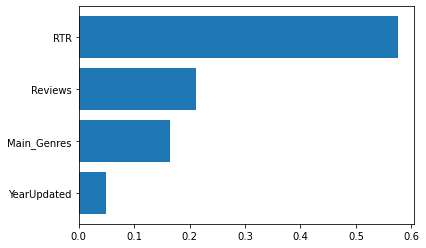

In [143]:
import matplotlib.pyplot as plt
from collections import OrderedDict

d={}
labels = []
sizes = []
for col, imp in zip(features, clf.feature_importances_):
    d[col]=imp

sort_d= {k: v for k, v in sorted(d.items(), key=lambda item: item[1])}
print(sort_d)

#Plot
plt.barh(*zip(*sort_d.items()))
plt.show()

- Evaluate the performance

In [144]:
print('MAE of TEST %s' %
      metrics.mean_absolute_error(y_test, y_pred))
print('\nMSE of TEST %s' %
      metrics.mean_squared_error(y_test, y_pred))
print('\nRMSE of TEST %s' %
      sqrt(mean_squared_error(y_test, y_pred)))

pearson_coef= stats.pearsonr(y_test, y_pred)
print("\nr TEST", pearson_coef[0])

ks= stats.ks_2samp(y_test, y_pred, alternative='two-sided', mode='auto')
print('\nKS TEST', ks[0])

MAE of TEST 0.34453029686864584

MSE of TEST 0.25084993899959335

RMSE of TEST 0.5008492178286729

r TEST 0.35621510820061636

KS TEST 0.22326148840992274


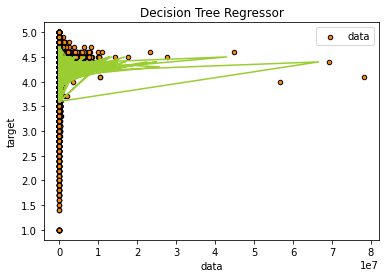

In [145]:
#DTR plot

plt.figure()
plt.scatter(np.array([item[0] for item in X_train.values]).reshape(X_train.shape[0],), y_train, s=20, edgecolor="black", c="darkorange", label="data")
plt.plot(X_test, y_pred, color="yellowgreen")
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regressor")
plt.legend()
plt.show()

In [146]:
import pydotplus
from sklearn import tree
from IPython.display import Image

In [147]:
dot_data = tree.export_graphviz(clf, out_file=None,
                                feature_names=features,  
                                filled=True, rounded=True,
                                special_characters=True,
                                max_depth=8)  
pydot_graph = pydotplus.graph_from_dot_data(dot_data)  
pydot_graph  = pydotplus.graph_from_dot_data(dot_data)  
pydot_graph.set_size('"50,50!"')
pydot_graph.write_png('tree.png')

True

## 2. Global Interpretation/Evaluation

In [148]:
df_dt = pd.DataFrame({'RatingPredict': y_pred, 'RatingActual': y_test, 'AbsDiffs': abs(y_pred-y_test)})

#df_dt['RatingPredict'] = pd.Series(y_pred)

#df_dt['RatingActual'] = pd.Series(y_test)

In [149]:
df_dt

,RatingPredict,RatingActual,AbsDiffs
8193,4.1,4.5,0.4
3373,4.5,4.8,0.3
4719,4.0,4.4,0.4
5439,4.4,4.1,0.3
5424,4.0,4.4,0.4
...,...,...,...
4350,4.2,4.2,0.0
4290,4.4,4.6,0.2
2081,4.1,4.6,0.5
1406,4.4,4.5,0.1


In [150]:
df_dt['RatingActual'][abs(df_dt['RatingActual'] - df_dt['RatingPredict']) <= 0].count()/df_dt['RatingActual'].count()

0.11061407076047174

In [151]:
df_dt[(abs(df_dt['RatingActual'] - df_dt['RatingPredict']) > 0) & (abs(df_dt['RatingActual'] - df_dt['RatingPredict']) <= 0.1)]

,RatingPredict,RatingActual,AbsDiffs
3104,4.1,4.0,0.1
1165,4.4,4.5,0.1
3015,4.4,4.5,0.1
1483,4.0,4.1,0.1
3774,4.4,4.5,0.1
...,...,...,...
6337,4.4,4.5,0.1
4244,4.5,4.6,0.1
831,4.5,4.4,0.1
4261,4.1,4.0,0.1


In [152]:
df_dt['RatingActual'].isnull().sum()

0

In [153]:
y_test.iloc[31]

3.7

In [154]:
df_dt[df_dt['RatingPredict'] == 3.6].count()

RatingPredict    49
RatingActual     49
AbsDiffs         49
dtype: int64

In [155]:
df_dt['RatingActual'][abs(df_dt['RatingActual'] - df_dt['RatingPredict']) <= 0.2].count()/df_dt['RatingActual'].count()

0.36396909312728754

In [156]:
df_dt['RatingActual'][abs(df_dt['RatingActual'] - df_dt['RatingPredict']) <= 0].value_counts()

4.4    64
4.3    55
4.1    47
4.2    32
4.5    31
4.0    28
3.9     8
3.8     3
4.7     2
3.6     2
Name: RatingActual, dtype: int64

In [157]:
diff_predict = dict()
tot_rows = df_dt['RatingActual'].count()

for i in np.arange(0.0,5.1,0.1):
    diff_count = df_dt['RatingActual'][(abs(df_dt['RatingActual'] - df_dt['RatingPredict']) > i-0.1) & (abs(df_dt['RatingActual'] - df_dt['RatingPredict']) <= i)].count()
    print(diff_count)
    diff_predict[i] = diff_count/tot_rows

272
283
340
615
209
277
106
72
85
36
56
29
12
13
6
12
9
4
5
2
5
4
1
2
4
2
2
0
3
0
0
2
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0


In [158]:
diff_predict

{0.0: 0.11061407076047174,
 0.1: 0.11508743391622611,
 0.2: 0.13826758845058967,
 0.30000000000000004: 0.25010166734444894,
 0.4: 0.08499389995933307,
 0.5: 0.11264741764945099,
 0.6000000000000001: 0.04310695404636031,
 0.7000000000000001: 0.029280195201301342,
 0.8: 0.03456689711264742,
 0.9: 0.014640097600650671,
 1.0: 0.02277348515656771,
 1.1: 0.011793411956079707,
 1.2000000000000002: 0.004880032533550223,
 1.3: 0.005286701911346075,
 1.4000000000000001: 0.0024400162667751117,
 1.5: 0.004880032533550223,
 1.6: 0.0036600244001626678,
 1.7000000000000002: 0.0016266775111834079,
 1.8: 0.0020333468889792597,
 1.9000000000000001: 0.0008133387555917039,
 2.0: 0.0020333468889792597,
 2.1: 0.0016266775111834079,
 2.2: 0.00040666937779585197,
 2.3000000000000003: 0.0008133387555917039,
 2.4000000000000004: 0.0016266775111834079,
 2.5: 0.0008133387555917039,
 2.6: 0.0008133387555917039,
 2.7: 0.0,
 2.8000000000000003: 0.0012200081333875558,
 2.9000000000000004: 0.0,
 3.0: 0.0,
 3.1: 0.0008

([<matplotlib.axis.XTick at 0x22744504430>,
 <a list of 26 Text major ticklabel objects>)

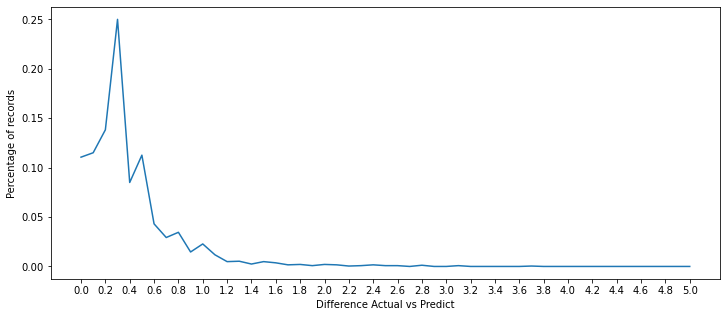

In [159]:
plt.figure(figsize = (12, 5))
plt.plot(list(diff_predict.keys()),list(diff_predict.values()))
plt.xlabel('Difference Actual vs Predict')
plt.ylabel('Percentage of records')
plt.xticks(np.arange(0.0,5.1,0.2))

In [160]:
df_dt = df_dt.sort_values(by = 'AbsDiffs')      #sort based on better predictions ('AbsDiffs' from 0 to max)

In [161]:
df[features].iloc[df_dt[-10:].index]            #worst predictions

,Reviews,Main_Genres,RTR,YearUpdated
6782,5,15,0.001248,2017
1681,23,30,0.057498,2016
6673,686,24,0.017148,2018
2124,33,44,0.008248,2017
6457,1,8,0.002498,2014
5752,2,42,0.001998,2018
1273,141,16,0.035248,2018
3156,1,26,0.002498,2016
4746,2,26,0.004998,2018
3906,1,14,0.024998,2018


In [162]:
df_first.iloc[df_dt[-10:].index]               #entire information about worst predictions

,App,Rating,Reviews,Size,Installs,Price,Content Rating,Current Ver,Android Ver,Main_Genres,Secondary_Genres,Is_Family,Is_Game,Compatibility,RTR,Both_Stores,YearUpdated,MonthUpdated
6782,BOSTON UNIVERSITY ALUMNI,1.8,5,5.2,3,0.00,1,1758,19,15,5,1,0,2,0.001248,0,2017,2
1681,SHAREDCARE™ CO-PARENTING,2.0,23,0.0,2,4.59,1,1454,12,30,5,0,0,2,0.057498,0,2016,6
6673,C BY GE,1.7,686,6.6,4,0.00,1,1796,18,24,5,0,0,2,0.017148,0,2018,11
2124,QUIZ DC,1.4,33,3.1,3,0.00,1,308,16,44,5,0,1,2,0.008248,0,2017,12
6457,CR MAGAZINE,1.0,1,7.8,2,0.00,1,1224,8,8,5,0,0,0,0.002498,0,2014,7
5752,DS CREATOR 2.0,1.0,2,4.4,12,0.00,1,972,12,42,5,0,0,2,0.001998,0,2018,3
1273,TAXLANDIA,1.9,141,65.0,3,0.00,1,721,18,16,5,1,0,2,0.035248,0,2018,6
3156,MBH BM,1.0,1,2.3,2,0.00,1,277,18,26,5,0,0,2,0.002498,0,2016,12
4746,FAMILIAL HYPERCHOLESTEROLAEMIA HANDBOOK,1.0,2,33.0,2,0.00,1,956,16,26,5,0,0,2,0.004998,0,2018,2
3906,HOUSE PARTY - LIVE CHAT,1.0,1,9.2,1,0.00,3,1662,14,14,5,0,0,2,0.024998,0,2018,7


Worst predictions share the same 'Content Rating' (Everyone), no 'Secondary_Genres', the same 'Compatibility' (Medium) and a very low 'RTR'.

## SHAP global explanation

In [163]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))

In [164]:
le_name_mapping

{'Action': 0,
 'Adventure': 1,
 'Arcade': 2,
 'Art & Design': 3,
 'Auto & Vehicles': 4,
 'Beauty': 5,
 'Board': 6,
 'Books & Reference': 7,
 'Business': 8,
 'Card': 9,
 'Casino': 10,
 'Casual': 11,
 'Comics': 12,
 'Communication': 13,
 'Dating': 14,
 'Education': 15,
 'Educational': 16,
 'Entertainment': 17,
 'Events': 18,
 'Finance': 19,
 'Food & Drink': 20,
 'Health & Fitness': 21,
 'House & Home': 22,
 'Libraries & Demo': 23,
 'Lifestyle': 24,
 'Maps & Navigation': 25,
 'Medical': 26,
 'Music': 27,
 'Music & Audio': 28,
 'News & Magazines': 29,
 'Parenting': 30,
 'Personalization': 31,
 'Photography': 32,
 'Productivity': 33,
 'Puzzle': 34,
 'Racing': 35,
 'Role Playing': 36,
 'Shopping': 37,
 'Simulation': 38,
 'Social': 39,
 'Sports': 40,
 'Strategy': 41,
 'Tools': 42,
 'Travel & Local': 43,
 'Trivia': 44,
 'Video Players & Editors': 45,
 'Weather': 46,
 'Word': 47}

In [165]:
import shap

shap.initjs()

In [166]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test)
shap_values

array([[-0.10316016, -0.05437104,  0.13185599, -0.03675121],
       [-0.06360649, -0.01636677,  0.3727716 ,  0.02397586],
       [-0.04569345, -0.02231234, -0.16199005,  0.01117018],
       ...,
       [ 0.08735875, -0.02898395, -0.1589997 ,  0.01576073],
       [ 0.12985029, -0.0016152 ,  0.04440067,  0.01859029],
       [-0.01192334, -0.00206096,  0.21630803, -0.16835191]])

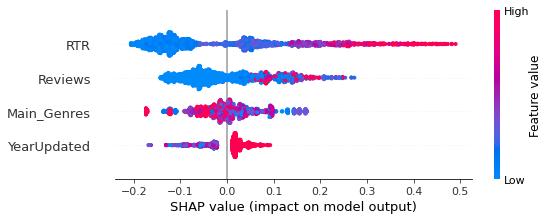

In [167]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_test)

1. Only high values in RTR push the rating up
2. Only high values in Reviews tends to increase the rating of an app
3. Many high values in Main_genres push the rating down, such as Weather, Social or Shopping
4. Newer is the year of the update for an app, higher is its rating

In [168]:
print(shap_values[:,2])

[ 0.13185599  0.3727716  -0.16199005 ... -0.1589997   0.04440067
  0.21630803]


In [169]:
unique_items, counts = np.unique(shap_values[:,2], return_counts=True)
for x,y in zip(unique_items, counts):
    print(x,y)

-0.20632610721314357 11
-0.2025990960993475 6
-0.19787682714644234 1
-0.19749515964198955 2
-0.1973380628337214 3
-0.19616976828105864 1
-0.19522947384742215 1
-0.19293397941575324 3
-0.192783149050734 4
-0.19261579388081645 1
-0.19203108114034367 5
-0.19112877640670808 7
-0.1901694690841283 1
-0.18996111866604637 2
-0.18912814272943684 4
-0.18863572730511535 1
-0.1885029386245069 5
-0.18740176529291203 3
-0.18553345095291301 1
-0.1834634884786157 1
-0.1832419053588808 3
-0.1831209410500266 8
-0.18308712615622486 1
-0.18267949634000685 1
-0.18258249951004454 1
-0.18213809711768447 2
-0.1815113539228642 17
-0.18101716368192755 1
-0.18097147698620636 2
-0.18014008956383265 2
-0.1796917723209963 1
-0.17843356509918115 15
-0.1783081869424717 2
-0.1775858182442985 5
-0.17689052760457283 7
-0.17635208606459077 1
-0.17607331160928769 1
-0.17547340499674244 1
-0.17483371019841093 2
-0.17445094234910308 2
-0.17393081192300136 2
-0.17359099280207244 5
-0.17358591798956652 1
-0.17343839649867987 

In [170]:
print(min(shap_values[:,2]))

-0.20632610721314357


## SHAP local explanation 

### The 10 Worst predictions

In [171]:
X_worst = df[features].iloc[df_dt[-10:].index].values
X_worst

array([[5.00000000e+00, 1.50000000e+01, 1.24835206e-03, 2.01700000e+03],
       [2.30000000e+01, 3.00000000e+01, 5.74984449e-02, 2.01600000e+03],
       [6.86000000e+02, 2.40000000e+01, 1.71483783e-02, 2.01800000e+03],
       [3.30000000e+01, 4.40000000e+01, 8.24836361e-03, 2.01700000e+03],
       [1.00000000e+00, 8.00000000e+00, 2.49835412e-03, 2.01400000e+03],
       [2.00000000e+00, 4.20000000e+01, 1.99835330e-03, 2.01800000e+03],
       [1.41000000e+02, 1.60000000e+01, 3.52484082e-02, 2.01800000e+03],
       [1.00000000e+00, 2.60000000e+01, 2.49835412e-03, 2.01600000e+03],
       [2.00000000e+00, 2.60000000e+01, 4.99835825e-03, 2.01800000e+03],
       [1.00000000e+00, 1.40000000e+01, 2.49983912e-02, 2.01800000e+03]])

In [172]:
y_worst = df_dt['RatingActual'][-10:]
worst_pred = df_dt['RatingPredict'][-10:]

In [173]:
#Actual
y_worst

6782    1.8
1681    2.0
6673    1.7
2124    1.4
6457    1.0
5752    1.0
1273    1.9
3156    1.0
4746    1.0
3906    1.0
Name: RatingActual, dtype: float64

In [174]:
#Predict
worst_pred

6782    4.2
1681    4.4
6673    4.3
2124    4.0
6457    3.8
5752    3.8
1273    4.7
3156    4.1
4746    4.1
3906    4.7
Name: RatingPredict, dtype: float64

In [175]:
shap_val_worst = explainer.shap_values(X_worst)
shap_val_worst

array([[-0.02482894,  0.16842954, -0.08063221, -0.02840398],
       [-0.01192334,  0.0298382 ,  0.35534885, -0.0970993 ],
       [-0.07150261, -0.04235292,  0.26178399,  0.01823991],
       [-0.11449028, -0.05424688,  0.07117383, -0.09230084],
       [-0.08353053, -0.11072898, -0.16807979, -0.02840398],
       [-0.09500324, -0.12530905, -0.20632611,  0.0468028 ],
       [ 0.01441738,  0.00585686,  0.45534674,  0.04746517],
       [-0.04238846,  0.09698056, -0.09640451, -0.03520885],
       [-0.05569617,  0.09318462, -0.13552653,  0.02101683],
       [ 0.02555246,  0.00208761,  0.42601182,  0.06943426]])

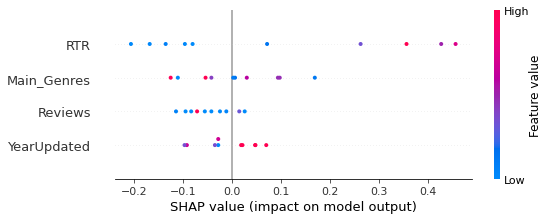

In [176]:
# summarize the effects of all the features
shap.summary_plot(shap_val_worst, X_worst, feature_names = ['Reviews', 'Main_Genres', 'RTR', 'YearUpdated'])

1. Only high values in RTR push the rating up
2. High values in Main_Genres tends to decrease the rating of two app
3. Most of low values in Reviews push the rating down
4. Newer is the year of the update for an app, higher is its rating

### The 10 best apps

In [177]:
X_best = df[features].iloc[df_dt[:10].index].values
X_best

array([[3.30000000e+01, 3.10000000e+01, 3.29984044e-02, 2.01600000e+03],
       [2.01450000e+04, 2.30000000e+01, 5.03460831e-03, 2.01300000e+03],
       [8.60625900e+06, 3.90000000e+01, 8.60462320e-03, 2.01800000e+03],
       [4.83782000e+05, 1.30000000e+01, 1.20929200e-02, 2.01800000e+03],
       [2.27820000e+04, 1.30000000e+01, 5.69385939e-03, 2.01500000e+03],
       [7.41200000e+03, 4.10000000e+01, 1.85283806e-02, 2.01800000e+03],
       [5.62000000e+02, 1.50000000e+01, 5.61835927e-03, 2.01700000e+03],
       [1.87200000e+05, 9.00000000e+00, 4.67835772e-03, 2.01800000e+03],
       [1.97979000e+05, 9.00000000e+00, 4.94931817e-02, 2.01800000e+03],
       [9.89344000e+05, 4.00000000e+01, 9.89180632e-03, 2.01800000e+03]])

In [178]:
y_best = df_dt['RatingActual'][:10]
best_pred = df_dt['RatingPredict'][:10]
y_best

5563    4.2
3186    4.1
4760    4.3
6341    4.4
1019    4.1
1128    4.4
6532    4.2
1160    4.3
5391    4.5
432     4.3
Name: RatingActual, dtype: float64

In [179]:
best_pred

5563    4.2
3186    4.1
4760    4.3
6341    4.4
1019    4.1
1128    4.4
6532    4.2
1160    4.3
5391    4.5
432     4.3
Name: RatingPredict, dtype: float64

In [180]:
shap_val_best = explainer.shap_values(X_best)
shap_val_best

array([[-0.01192334, -0.00206096,  0.21630803, -0.16835191],
       [ 0.10547534, -0.01346231, -0.10806584, -0.08385338],
       [ 0.13511061, -0.01426626,  0.03324457,  0.01810656],
       [ 0.15973853,  0.00471762,  0.06601692,  0.01709134],
       [ 0.06662942, -0.00791053, -0.10682563, -0.05179944],
       [-0.01950232, -0.00121244,  0.24450372,  0.04519969],
       [-0.04076349,  0.17062137, -0.07060783, -0.02468564],
       [ 0.27311847, -0.04656202, -0.09325909,  0.01106365],
       [ 0.07136739, -0.01084294,  0.28298009,  0.02669622],
       [ 0.14007578, -0.02883507,  0.0428482 ,  0.01810656]])

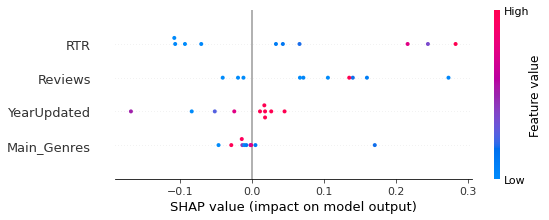

In [181]:
# summarize the effects of all the features
shap.summary_plot(shap_val_best, X_best, feature_names = ['Reviews', 'Main_Genres', 'RTR', 'YearUpdated'])

1. Only high values in RTR push the rating up
2. Low values in Reviews tends to increase or to decrease the rating of apps (only one high value increases the rating)
3. Newer is the year of the update for an app, higher is its rating
4. Low values in Main_genres push the rating up, such as Action, Arcade and Business

### Some popular apps

In [182]:
feats_names = ['Reviews', 'Main_Genres', 'RTR', 'YearUpdated']

- **FACEBOOK**

In [183]:
df_first[df_first['App'] == 'FACEBOOK']

,App,Rating,Reviews,Size,Installs,Price,Content Rating,Current Ver,Android Ver,Main_Genres,Secondary_Genres,Is_Family,Is_Game,Compatibility,RTR,Both_Stores,YearUpdated,MonthUpdated
4764,FACEBOOK,4.1,78158306,0.0,9,0.0,4,2571,30,39,5,0,0,3,0.019538,1,2018,3


In [184]:
facebook = df[features].iloc[4764].values

shap_val_fb = explainer.shap_values(facebook)

# plot the SHAP values for the observation 
shap.force_plot(explainer.expected_value, shap_val_fb, facebook, feature_names = feats_names)

Only 'Main_Genres' push the rating value down.

- **INSTAGRAM**

In [185]:
df_first[df_first['App'] == 'INSTAGRAM']

,App,Rating,Reviews,Size,Installs,Price,Content Rating,Current Ver,Android Ver,Main_Genres,Secondary_Genres,Is_Family,Is_Game,Compatibility,RTR,Both_Stores,YearUpdated,MonthUpdated
3774,INSTAGRAM,4.5,66577446,0.0,9,0.0,4,2571,30,39,5,0,0,3,0.016643,1,2018,7


In [186]:
instagram = df[features].iloc[3774].values

shap_val_ig = explainer.shap_values(instagram)

# plot the SHAP values for the observation 
shap.force_plot(explainer.expected_value, shap_val_ig, instagram, feature_names = feats_names)

Only 'Main_Genres' pushes the rating value down.

- **TWITTER**

In [187]:
df_first[df_first['App'] == 'TWITTER']

,App,Rating,Reviews,Size,Installs,Price,Content Rating,Current Ver,Android Ver,Main_Genres,Secondary_Genres,Is_Family,Is_Game,Compatibility,RTR,Both_Stores,YearUpdated,MonthUpdated
880,TWITTER,4.3,11667403,0.0,18,0.0,3,2571,30,29,5,0,0,3,0.011666,1,2018,6


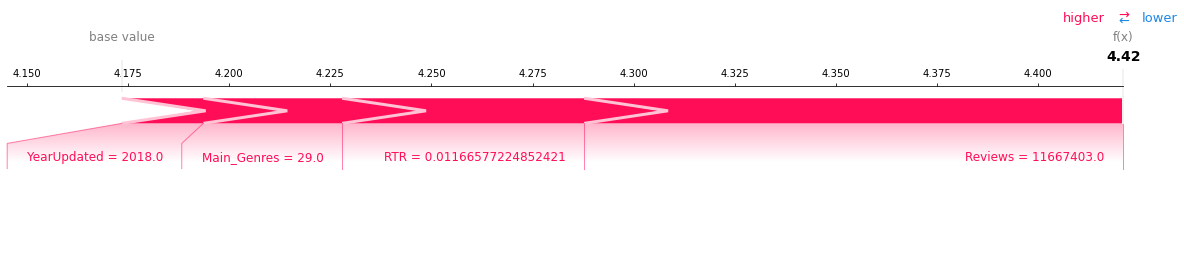

In [200]:
twitter = df[features].iloc[880].values

shap_val_tw = explainer.shap_values(twitter)

# plot the SHAP values for the observation 
shap.force_plot(explainer.expected_value, shap_val_tw, twitter, feature_names = feats_names, show=False,matplotlib=True).savefig('scratch.png',format = "png",dpi = 150,bbox_inches = 'tight')

All the features push the rating up.

- **YOUTUBE**

In [189]:
df_first[df_first['App'] == 'YOUTUBE']

,App,Rating,Reviews,Size,Installs,Price,Content Rating,Current Ver,Android Ver,Main_Genres,Secondary_Genres,Is_Family,Is_Game,Compatibility,RTR,Both_Stores,YearUpdated,MonthUpdated
361,YOUTUBE,4.3,25655305,0.0,9,0.0,4,2571,30,45,5,0,0,3,0.006412,0,2018,2


In [190]:
youtube = df[features].iloc[361].values

shap_val_yt = explainer.shap_values(youtube)

# plot the SHAP values for the 10th observation 
shap.force_plot(explainer.expected_value, shap_val_yt, youtube, feature_names = feats_names)

Only 'Main_Genres' pushes the rating value down.

- **AMAZON SHOPPING**

In [191]:
df_first[df_first['App'] == 'AMAZON SHOPPING']

,App,Rating,Reviews,Size,Installs,Price,Content Rating,Current Ver,Android Ver,Main_Genres,Secondary_Genres,Is_Family,Is_Game,Compatibility,RTR,Both_Stores,YearUpdated,MonthUpdated
7634,AMAZON SHOPPING,4.3,909226,42.0,8,0.0,4,903,19,37,5,0,0,2,0.002271,0,2018,7


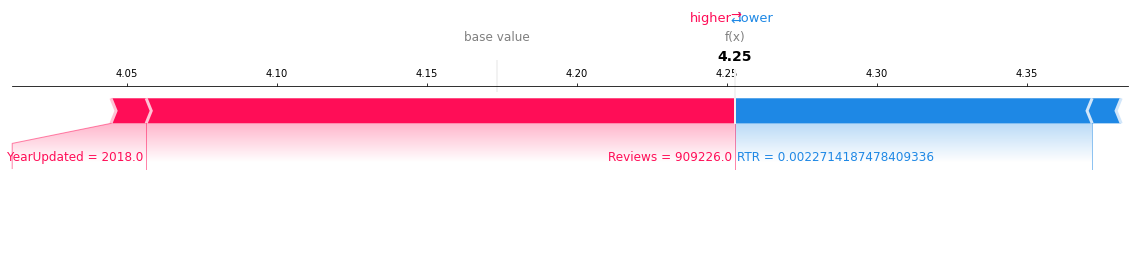

In [192]:
amazon = df[features].iloc[7634].values

shap_val_amz = explainer.shap_values(amazon)

# plot the SHAP values for the observation 
shap.force_plot(explainer.expected_value, shap_val_amz, amazon, feature_names = feats_names,show=False,matplotlib=True).savefig('scratch.png',format = "png",dpi = 150,bbox_inches = 'tight')

'RTR' and 'Main_Genres' push the rating value down.

### Google Apps

In [193]:
df_first[df_first['App'].str.contains("GOOGLE")]

,App,Rating,Reviews,Size,Installs,Price,Content Rating,Current Ver,Android Ver,Main_Genres,Secondary_Genres,Is_Family,Is_Game,Compatibility,RTR,Both_Stores,YearUpdated,MonthUpdated
2128,QUICKPIC - PHOTO GALLERY WITH GOOGLE DRIVE SUP...,4.6,847159,4.2,7,0.0,1,1953,12,32,5,0,0,2,0.021177,0,2017,10
2198,PROJECT FI BY GOOGLE,4.6,7342,0.0,6,0.0,1,2571,24,42,5,0,0,2,0.001834,0,2018,7
2364,PHOTOSCAN BY GOOGLE PHOTOS,4.3,61990,0.0,7,0.0,1,602,23,32,5,0,0,2,0.001548,1,2018,9
2497,PHONE FOR GOOGLE VOICE & GTALK,4.3,72065,13.0,6,0.0,1,1464,12,13,5,0,0,2,0.018015,0,2018,4
2576,ONE TODAY BY GOOGLE,4.5,2586,9.4,5,0.0,1,747,14,24,5,0,0,2,0.006463,0,2015,12
3364,LOCAL SERVICES ADS BY GOOGLE,4.1,7,12.0,3,0.0,1,1598,12,8,5,0,0,2,0.001748,0,2018,7
4177,GOOGLE+,4.2,4831125,0.0,9,0.0,4,2571,30,39,5,0,0,3,0.001206,0,2018,7
4178,GOOGLE APP FOR ANDROID TV,3.0,66,0.0,7,0.0,1,2571,30,42,5,0,0,3,0.000000,0,2018,7
4179,GOOGLE VOICE,4.2,171052,0.0,7,0.0,1,2571,30,13,5,0,0,3,0.004275,0,2018,3
4180,GOOGLE TRIPS - TRAVEL PLANNER,4.1,26871,0.0,16,0.0,1,310,16,43,5,0,0,2,0.002685,0,2018,7


In [194]:
google_index = df_first[df_first['App'].str.contains("GOOGLE")].index

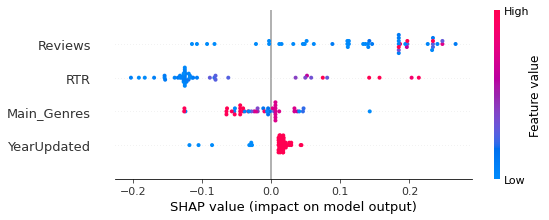

In [195]:
X_google = df[features].iloc[google_index].values

shap_val_gg = explainer.shap_values(X_google)

# summarize the effects of all the features
shap.summary_plot(shap_val_gg, X_google, feature_names = feats_names)

1. Very high number of Reviews pushes the rating up, but in general also low number of Reviews tends to increase the rating
2. High levels of RTR increase the rating and low levels decrease it
3. High values of Main_Genres tends to decrease the rating
4. Newer updates determine increasing rating values

# LORE

In [362]:
import sys
import pandas as pd

sys.path.append(r'C:\Users\aldoi\Desktop\Università di Pisa\Big Data\GooglePlayProg\Codici\LOREM-master\code')

from lorem import LOREM
from util import record2str, neuclidean, multilabel2str

from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from datamanager import *

In [363]:
class_name = 'Rating'
class_name_map = {v: k for k, v in enumerate(sorted(df[class_name].unique()))}
class_values = sorted(class_name_map)
numeric_columns = [col for col in df.columns if col != 'Rating']

In [364]:
rdf = df.copy(deep = True)

In [365]:
def get_real_feature_names(rdf, numeric_columns, class_name):
    real_feature_names = [c for c in rdf.columns if c in numeric_columns and c != class_name]
    real_feature_names += [c for c in rdf.columns if c not in numeric_columns and c != class_name]
    return real_feature_names

In [366]:
real_feature_names = get_real_feature_names(rdf, numeric_columns, class_name)

In [367]:
def get_features_map(features, real_feature_names):
    features_map = defaultdict(dict)
    i = 0
    j = 0

    while i < len(features) and j < len(real_feature_names):
        if features[i] == real_feature_names[j]:
            features_map[j][features[i]] = j
            i += 1
            j += 1
        elif features[i].startswith(real_feature_names[j]):
            features_map[j][features[i]] = j
            i += 1
        else:
            j += 1
    return features_map

In [368]:
features_map = get_features_map(features, real_feature_names)

## Top 10 Apps

In [369]:
X_test_top=df[features].loc[i]

In [370]:
y_test_top=df[class_name].loc[i]

In [371]:
stratify = None if isinstance(class_name, list) else df[class_name].values
X_train,X_test, Y_train,Y_test = train_test_split(df[features].values, df[class_name].values, test_size=0.30,
                                                    random_state=42, stratify=stratify)
stratify = None if isinstance(class_name, list) else rdf[class_name].values
_, K, _, _ = train_test_split(rdf[real_feature_names].values, rdf[class_name].values, test_size=0.30,
                              random_state=42, stratify=stratify)

In [372]:
bb = tree.DecisionTreeRegressor(max_depth=8, min_samples_leaf=100, random_state=42)

Model learning

In [373]:
bb.fit(X_train, Y_train)

DecisionTreeRegressor(max_depth=8, min_samples_leaf=100, random_state=42)

In [374]:
X_test_top= np.array(X_test_top)
X_test_top

array([[7.81583060e+07, 3.90000000e+01, 1.95379587e-02, 2.01800000e+03],
       [6.91193160e+07, 1.30000000e+01, 1.72782075e-02, 2.01800000e+03],
       [6.65774460e+07, 3.90000000e+01, 1.66427390e-02, 2.01800000e+03],
       [5.66465780e+07, 1.30000000e+01, 1.41600179e-02, 2.01800000e+03],
       [2.77253520e+07, 2.00000000e+00, 6.92969943e-03, 2.01800000e+03],
       [2.56553050e+07, 4.50000000e+01, 6.41218683e-03, 2.01800000e+03],
       [1.08590510e+07, 3.20000000e+01, 2.71311723e-03, 2.01800000e+03],
       [1.04841690e+07, 1.30000000e+01, 2.61939657e-03, 2.01800000e+03],
       [9.64304100e+06, 1.30000000e+01, 2.40911423e-03, 2.01800000e+03],
       [9.23537300e+06, 4.30000000e+01, 2.30719706e-03, 2.01800000e+03]])

Application of LORE on test set

In [375]:
for x in range(0,10):
    i2e =x
    x = X_test_top[i2e]

    print('x = %s' % record2str(x, features, numeric_columns))
    print('')
    
    def bb_predict(X):
        bb_pred = bb.predict(X).astype(int)
        return bb_pred
    
    bb_outcome = bb_predict(x.reshape(1, -1))[0]
    bb_outcome = bb_outcome.astype(int)
    bb_outcome_str = class_values[bb_outcome]
    print('bb(x) = { %s }' % bb_outcome_str)
    print('')
    
    explainer = LOREM(K, bb_predict, features, class_name, class_values, numeric_columns, features_map,
                          neigh_type='rndgen', categorical_use_prob=True,
                          continuous_fun_estimation=False, size=1000, ocr=0.1, multi_label=False, one_vs_rest=False,
                          random_state=42, verbose=False, ngen=10)
    exp = explainer.explain_instance(x, samples=1000, use_weights=True, metric=neuclidean)
    print("index", i,": ")
    print('e = {\n\tr = %s\n\tc = %s    \n}' % (exp.rstr(), exp.cstr()))
    print('__________________________________________________________________________________________________________')

x = { Reviews = 78158306.0, Main_Genres = 39.0, RTR = 0.019537958737631915, YearUpdated = 2018.0 }

bb(x) = { 33 }

index Int64Index([4764, 530, 3774, 3099, 1388, 361, 4189, 1603, 4205, 3195], dtype='int64') : 
e = {
	r = { RTR <= 0.06, RTR > 0.01, Main_Genres > 35.50, YearUpdated > 2017.38, Reviews > -551430.47 } --> { Rating: 33 }
	c = { { RTR <= 0.01 } --> { Rating: 32 }, { RTR <= 0.01 } --> { Rating: 32 }, { RTR <= 0.00 } --> { Rating: 31 }, { YearUpdated <= 2017.38 } --> { Rating: 31 }, { Main_Genres <= 21.50 } --> { Rating: 34 }, { Main_Genres <= 35.50 } --> { Rating: 34 }, { RTR > 0.06 } --> { Rating: 35 }, { RTR <= 0.01 } --> { Rating: 31 } }    
}
__________________________________________________________________________________________________________
x = { Reviews = 69119316.0, Main_Genres = 13.0, RTR = 0.017278207509042392, YearUpdated = 2018.0 }

bb(x) = { 33 }

index Int64Index([4764, 530, 3774, 3099, 1388, 361, 4189, 1603, 4205, 3195], dtype='int64') : 
e = {
	r = { RTR 

## Worst  10 Prediction

In [376]:
worstdf = df.loc[indeces]
worstdf

,Rating,Reviews,Main_Genres,RTR,YearUpdated
3906,0,1,14,0.024998,2018
4746,0,2,26,0.004998,2018
3156,0,1,26,0.002498,2016
1273,7,141,16,0.035248,2018
6673,5,686,24,0.017148,2018
2124,2,33,44,0.008248,2017
5752,0,2,42,0.001998,2018
6457,0,1,8,0.002498,2014
1681,8,23,30,0.057498,2016
6782,6,5,15,0.001248,2017


In [377]:
worstdf = worstdf.drop('Rating', axis = 1)
worstdf

,Reviews,Main_Genres,RTR,YearUpdated
3906,1,14,0.024998,2018
4746,2,26,0.004998,2018
3156,1,26,0.002498,2016
1273,141,16,0.035248,2018
6673,686,24,0.017148,2018
2124,33,44,0.008248,2017
5752,2,42,0.001998,2018
6457,1,8,0.002498,2014
1681,23,30,0.057498,2016
6782,5,15,0.001248,2017


In [378]:
X_test = np.array(worstdf)
X_test

array([[1.00000000e+00, 1.40000000e+01, 2.49983912e-02, 2.01800000e+03],
       [2.00000000e+00, 2.60000000e+01, 4.99835825e-03, 2.01800000e+03],
       [1.00000000e+00, 2.60000000e+01, 2.49835412e-03, 2.01600000e+03],
       [1.41000000e+02, 1.60000000e+01, 3.52484082e-02, 2.01800000e+03],
       [6.86000000e+02, 2.40000000e+01, 1.71483783e-02, 2.01800000e+03],
       [3.30000000e+01, 4.40000000e+01, 8.24836361e-03, 2.01700000e+03],
       [2.00000000e+00, 4.20000000e+01, 1.99835330e-03, 2.01800000e+03],
       [1.00000000e+00, 8.00000000e+00, 2.49835412e-03, 2.01400000e+03],
       [2.30000000e+01, 3.00000000e+01, 5.74984449e-02, 2.01600000e+03],
       [5.00000000e+00, 1.50000000e+01, 1.24835206e-03, 2.01700000e+03]])

Application of LORE Algorithm on test set

In [379]:
 for i in range(0,10):
    i2e = i
    x = X_test[i2e]

    #print('x = %s' % record2str(x, features, numeric_columns))
    #print('')
    def bb_predict(X):
        bb_pred = bb.predict(X).astype(int)
        return bb_pred
    bb_outcome = bb_predict(x.reshape(1, -1))[0]
    bb_outcome = bb_outcome.astype(int)
    bb_outcome_str = class_values[bb_outcome]
    #print('bb(x) = { %s }' % bb_outcome_str)
    #print('')
    explainer = LOREM(K, bb_predict, features, class_name, class_values, numeric_columns, features_map,
                          neigh_type='rndgen', categorical_use_prob=True,
                          continuous_fun_estimation=False, size=1000, ocr=0.1, multi_label=False, one_vs_rest=False,
                          random_state=42, verbose=False, ngen=10)
    exp = explainer.explain_instance(x, samples=1000, use_weights=True, metric=neuclidean)
    print("index", i,": ")
    print('bb(x) = { %s }' % bb_outcome_str)
    print('e = {\n\tr = %s\n\tc = %s    \n}' % (exp.rstr(), exp.cstr()))

index 0 : 
bb(x) = { 35 }
e = {
	r = { RTR > 0.02, Reviews <= 144.00, YearUpdated > 2017.52 } --> { Rating: 35 }
	c = { { Reviews > 144.00 } --> { Rating: 34 }, { RTR <= 0.01 } --> { Rating: 31 }, { RTR <= 0.02 } --> { Rating: 32 }, { RTR <= 0.01 } --> { Rating: 28 }, { YearUpdated <= 2017.52 } --> { Rating: 32 }, { YearUpdated <= 2014.50 } --> { Rating: 32 } }    
}
index 1 : 
bb(x) = { 29 }
e = {
	r = { RTR <= 0.01, Reviews <= 20377.50, Reviews > -3345422.75, Main_Genres <= 31.48, Main_Genres > 25.42 } --> { Rating: 29 }
	c = { { Main_Genres <= 25.42 } --> { Rating: 27 }, { Reviews > 131709.83 } --> { Rating: 32 }, { RTR > 0.01 } --> { Rating: 31 }, { RTR > 0.03 } --> { Rating: 35 }, { RTR > 0.01 } --> { Rating: 34 }, { Main_Genres > 41.50 } --> { Rating: 26 }, { Reviews > 20377.50 } --> { Rating: 31 }, { Main_Genres <= 15.68 } --> { Rating: 31 }, { Main_Genres <= 7.50 } --> { Rating: 30 }, { Main_Genres > 31.48 } --> { Rating: 28 }, { Main_Genres <= 14.52 } --> { Rating: 28 }, { Mai